# Computational Efficiency

*Code to create Figure 3d in [Saliency Cards: A Framework to Characterize and Compare
Saliency Methods](https://arxiv.org/abs/2206.02958).*

Computational efficiency measureshow computationally intensive it is to produce the saliency map. Different methods vary widely in their computational efficiency. For example, perturbation-based methods are often more computationally intensive than simple gradient-based methods.

To illustrate computational efficiency, we time three common saliency methods: [guided backprop](https://arxiv.org/abs/1412.6806), [integrated gradients](https://arxiv.org/abs/1703.01365), [smoothgrad](https://arxiv.org/abs/1706.03825), and [LIME](https://arxiv.org/abs/1602.04938), showing that compute time can vary by orders of magnitude between saliency methods.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from saliency_methods.gradcam import GradCAM
from saliency_methods.gradient_shap import GradientSHAP
from saliency_methods.guided_backprop import GuidedBackprop
from saliency_methods.input_x_gradient import InputXGradient
from saliency_methods.integrated_gradients import IntegratedGradients
from saliency_methods.kernel_shap import KernelSHAP
from saliency_methods.lime_method import LIME
from saliency_methods.rise import RISE
from saliency_methods.sis import SIS
from saliency_methods.vanilla_gradients import VanillaGradients
from saliency_methods.util import visualize_saliency
from saliency_methods.xrai import XRAI
from util import imagenet_transform, load_model_from_pytorch, load_pil_image

## Load ImageNet Image and Pretrained ResNet50 Model
To time each saliency method, we compute the saliency of a ResNet50 model on an ImageNet (3, 224, 244) image.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model_from_pytorch('resnet50', True, device).eval()

We select an image to evaluate.

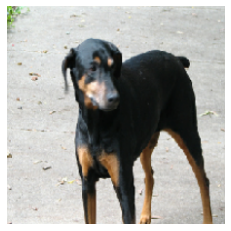

In [4]:
image_path = './resources/doberman.png'
image = load_pil_image(image_path)

model_transform = imagenet_transform(normalize=True)
display_transform = imagenet_transform(normalize=False)

image_input = model_transform(image)
plt.imshow(display_transform(image).numpy().transpose(1, 2, 0))
plt.axis('off');

In [5]:
image_batch = image_input.unsqueeze(0).to(device)

## Time Saliency Methods
We time [guided backprop](https://arxiv.org/abs/1412.6806), [integrated gradients](https://arxiv.org/abs/1703.01365), [smoothgrad](https://arxiv.org/abs/1706.03825), and [LIME](https://arxiv.org/abs/1602.04938). We use each method's default parameters and a public implementation. To achieve a consistent interface, we use the [interpretability-methods repo](https://github.com/aboggust/interpretability-methods) that wraps each implementation. 

### Guided Backprop
We use the [Captum](https://captum.ai/api/guided_backprop.html) implementation of guided backprop.

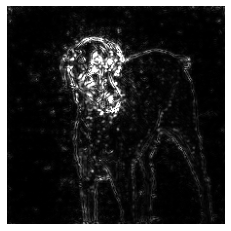

In [7]:
gb = GuidedBackprop(model)
gb_saliency = gb.get_saliency(image_batch)
visualize_saliency(gb_saliency);

In [8]:
%timeit gb.get_saliency(image_batch)

59.6 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Integrated Gradients
We use the [Captum](https://captum.ai/api/guided_backprop.html) implementation of integrated gradients and its default parameters (baseline of random noise and 50 approximation steps).

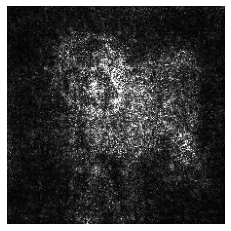

In [9]:
ig = IntegratedGradients(model)
ig_saliency = ig.get_saliency(image_batch)
visualize_saliency(ig_saliency);

In [10]:
%timeit ig.get_saliency(image_batch)

159 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### SmoothGrad
We implement SmoothGrad based on the [PAIR Saliency](https://github.com/PAIR-code/saliency) implementation and its default parameters (15% noise and 25 samples).

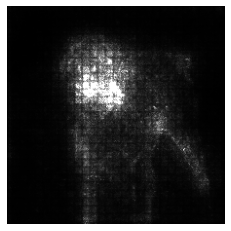

In [11]:
vg = VanillaGradients(model)
smoothgraph_saliency = vg.get_saliency_smoothed(image_batch)
visualize_saliency(smoothgraph_saliency);

In [12]:
%timeit vg.get_saliency_smoothed(image_batch)

1.53 s ± 28.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### LIME
We use [the author's LIME package](https://github.com/marcotcr/lime) and its default parameters on ImageNet images (1000 samples).

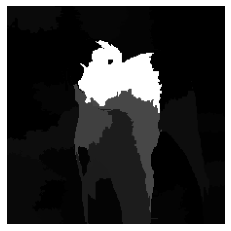

In [13]:
lime = LIME(model)
lime_saliency = lime.get_saliency(image_batch)
visualize_saliency(lime_saliency);

In [14]:
%timeit lime.get_saliency(image_batch)


13.1 s ± 501 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Timing for Other Saliency Methods

### Grad-CAM
We time Grad-CAM using the Captum implementation and interpolation.

/nobackup/users/aboggust/bin/miniconda3/envs/wml/lib/python3.6/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


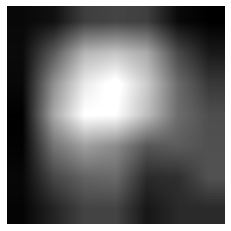

In [15]:
gradcam = GradCAM(model, model.module.layer4)
gradcam_saliency = gradcam.get_saliency(image_batch)
visualize_saliency(gradcam_saliency);

In [16]:
%timeit gradcam.get_saliency(image_batch)

45.3 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Vanilla Gradients
We time vanilla gradients using the Captum implementation.

/nobackup/users/aboggust/bin/miniconda3/envs/wml/lib/python3.6/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


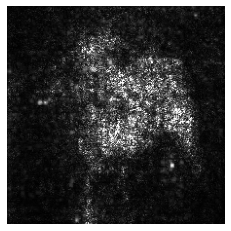

In [17]:
vg_saliency = vg.get_saliency(image_batch)
visualize_saliency(vg_saliency);

In [18]:
%timeit vg.get_saliency(image_batch)

56.5 ms ± 39.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Integrated Gradients + SmoothGrad
We use the [Captum](https://captum.ai/api/guided_backprop.html) implementation of integrated gradients and its default parameters (baseline of random noise and 50 approximation steps). We implement SmoothGrad based on the [PAIR Saliency](https://github.com/PAIR-code/saliency) implementation and its default parameters (15% noise and 25 samples).

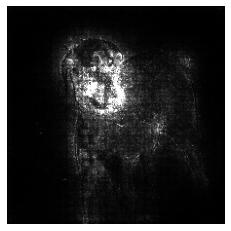

In [19]:
ig = IntegratedGradients(model)
ig_saliency = ig.get_saliency_smoothed(image_batch)
visualize_saliency(ig_saliency);

In [20]:
%timeit ig.get_saliency_smoothed(image_batch)

4.17 s ± 167 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Input X Gradient 
We use the [Captum](https://captum.ai/api/input_x_gradient.html) implementation of input x gradient.

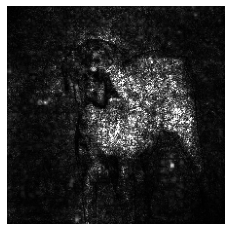

In [21]:
ixg = InputXGradient(model)
ixg_saliency = ixg.get_saliency(image_batch)
visualize_saliency(ixg_saliency);

In [22]:
%timeit ixg.get_saliency(image_batch)

56.5 ms ± 88.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### XRAI
We use the [Google Pair Saliency](https://github.com/PAIR-code/saliency/tree/master) implementation of XRAI.

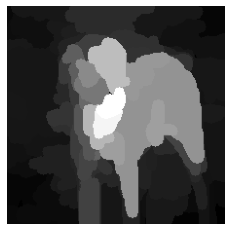

In [23]:
xrai = XRAI(model)
xrai_saliency = xrai.get_saliency(image_batch)
visualize_saliency(xrai_saliency);

In [24]:
%timeit xrai.get_saliency(image_batch)

16.1 s ± 3.14 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### RISE
We use the [RISE GitHub](https://github.com/eclique/RISE/tree/master) implementation.

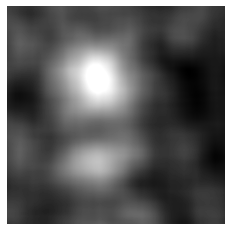

In [25]:
input_size = tuple(image_batch[0].shape)[1:]
rise = RISE(model, input_size=input_size)
rise_saliency = rise.get_saliency(image_batch).squeeze(0)
visualize_saliency(rise_saliency);

In [26]:
%timeit rise.get_saliency(image_batch)

725 ms ± 4.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### GradientSHAP
We use the [Captum](https://captum.ai/api/gradient_shap.html) implementation of GradientSHAP.

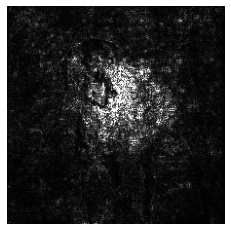

In [27]:
gradient_shap = GradientSHAP(model)
gradient_shap_saliency = gradient_shap.get_saliency(image_batch)
visualize_saliency(gradient_shap_saliency);

In [28]:
%timeit gradient_shap.get_saliency(image_batch)

113 ms ± 7.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### KernelSHAP
We use the [Captum](https://captum.ai/api/kernel_shap.html) implementation of KernelSHAP.

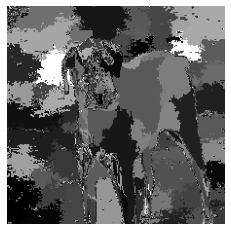

In [29]:
kernel_shap = KernelSHAP(model)
kernel_shap_saliency = kernel_shap.get_saliency(image_batch)
visualize_saliency(kernel_shap_saliency);

In [30]:
%timeit kernel_shap.get_saliency(image_batch)

3.46 s ± 499 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### SIS
We use the [author's implementation](https://github.com/gifford-lab/overinterpretation) of SIS.

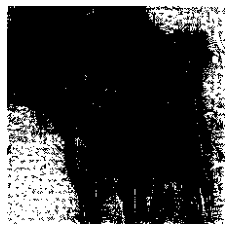

In [31]:
sis = SIS(model)
sis_saliency = sis.get_saliency(image_batch)
visualize_saliency(sis_saliency);

In [32]:
%timeit sis.get_saliency(image_batch)

24.8 s ± 487 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
